Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Embedding
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Load the dataset

In [2]:
df = pd.read_csv('IMDB Dataset.csv/IMDB Dataset.csv')


In [3]:
print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [4]:
print(df['sentiment'].value_counts())


sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [5]:
df.shape

(50000, 2)

In [6]:

df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [7]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [8]:
df.duplicated().sum()

418

## Basic Preprocessing
1. Remove tags - HTML
2. Lower case

In [9]:
import re

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<br />', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    return text

df['review'] = df['review'].apply(preprocess_text)

# Map sentiment to binary labels
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})


In [10]:
df.review[0]

'one of the other reviewers has mentioned that after watching just  oz episode youll be hooked they are right as this is exactly what happened with me  the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word  it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away  i would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty p

In [11]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['review'])
word_index = tokenizer.word_index

# Pad sequences
max_length = 200  # Define max sequence length
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Target variable
y = df['sentiment'].values


In [12]:
# Split reviews into tokenized words
tokenized_reviews = [review.split() for review in df['review']]

# Train Word2Vec
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

# Create an embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#  LSTM model
model = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=100,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Enable fine-tuning Word2Vec embeddings
    LSTM(units=128, return_sequences=False), 
    Dropout(0.5), 
    Dense(units=64, activation='relu'),  
    Dropout(0.5),  
    Dense(units=1, activation='sigmoid') 
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display  model summary
model.summary()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), 
    ModelCheckpoint(filepath='best_lstm_model.keras', save_best_only=True, monitor='val_loss')  
]

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,  # Use a part of the training data for validation
    callbacks=callbacks
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │    16,330,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,330,400 (62.30 MB)

 Trainable params: 16,330,400 (62.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 209s 413ms/step - accuracy: 0.5386 - loss: 0.6917 - val_accuracy: 0.5008 - val_loss: 0.6934
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 164s 327ms/step - accuracy: 0.5088 - loss: 0.6935 - val_accuracy: 0.5306 - val_loss: 0.6917
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 177s 355ms/step - accuracy: 0.5454 - loss: 0.6835 - val_accuracy: 0.7736 - val_loss: 0.4955
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 172s 344ms/step - accuracy: 0.8207 - loss: 0.4461 - val_accuracy: 0.8720 - val_loss: 0.3017
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 155s 310ms/step - accuracy: 0.9077 - loss: 0.2595 - val_accuracy: 0.8811 - val_loss: 0.3019
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 283ms/step - accuracy: 0.9597 - loss: 0.1306 - val_accuracy: 0.8791 - val_loss: 0.3640
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 136s 271ms/step - accuracy: 0.9841 - loss: 0.0605 - val_accuracy: 0.8711 - val_loss: 0.4380


Evaluate

In [17]:
#  on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8747 - loss: 0.2964
Test Accuracy: 0.87
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
              precision    recall  f1-score   support

           0       0.86      0.90      0.87      4961
           1       0.89      0.85      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



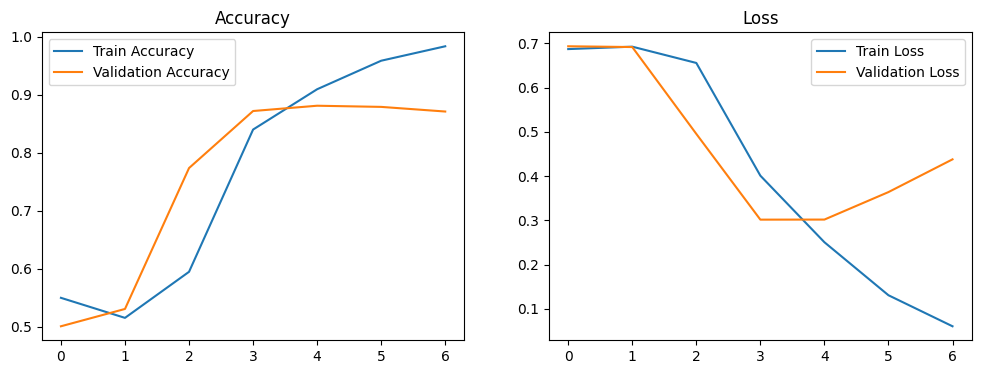

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


Confidence Matrix

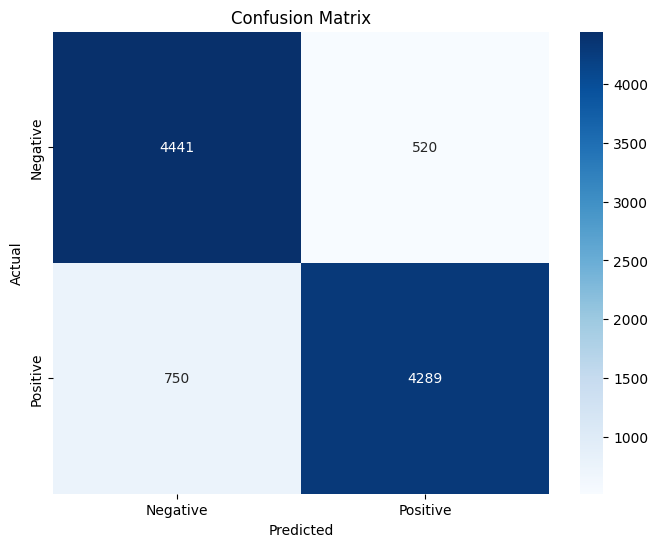

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()